<a href="https://colab.research.google.com/github/Rawan-C0de/traffic-forecasting/blob/main/Predicting_the_Future.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install sktime

In [2]:
pip install numpy==1.26.4


In [17]:
!pip uninstall -y prophet fbprophet cmdstanpy
!pip install prophet --quiet

Found existing installation: prophet 1.1.7
Uninstalling prophet-1.1.7:
  Successfully uninstalled prophet-1.1.7
Found existing installation: cmdstanpy 1.3.0
Uninstalling cmdstanpy-1.3.0:
  Successfully uninstalled cmdstanpy-1.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 6.9 MB/s eta 0:00:00


In [3]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import pandas as pd
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_error, r2_score
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
import matplotlib.pyplot as plt
import numpy as np


In [4]:
from prophet import Prophet


In [5]:
y = pd.DataFrame(load_airline())
y

,Number of airline passengers
Period,
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0
...,...
1960-08,606.0
1960-09,508.0
1960-10,461.0


<Axes: xlabel='Period'>

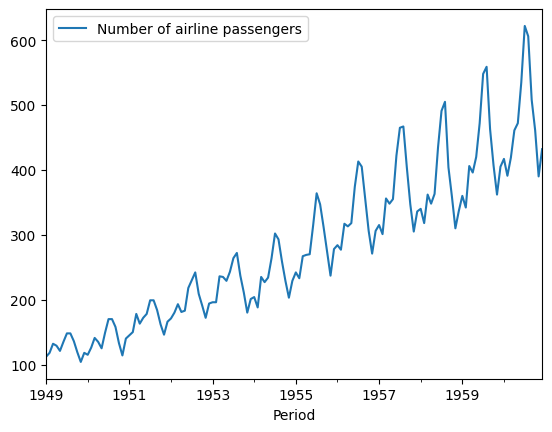

In [6]:
y.plot()

In [7]:
y_train, y_test = temporal_train_test_split(y, train_size=0.8)
fh = ForecastingHorizon(y_test.index, is_relative=False)
forcaster = ThetaForecaster(sp=12)
forcaster.fit(y_train)


ThetaForecaster(sp=12)

In [8]:
y_pred = forcaster.predict(fh)


In [9]:
y_pred

,Number of airline passengers
1958-08,488.773992
1958-09,433.371044
1958-10,377.148305
1958-11,329.001969
1958-12,372.409438
1959-01,376.347960
1959-02,372.122092
1959-03,427.725595
1959-04,410.511117
1959-05,409.564305


In [10]:
mean_absolute_percentage_error(y_test, y_pred)

0.06908937018559058

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

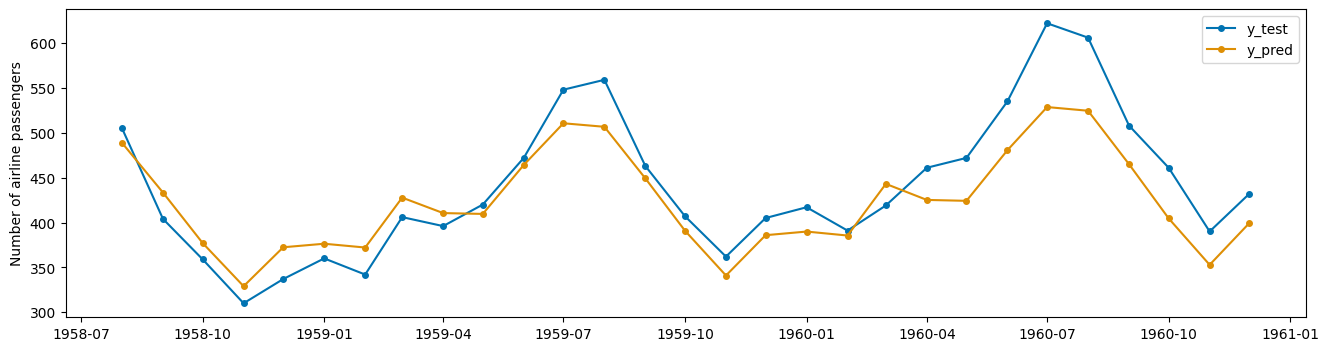

In [11]:
plot_series(y_test, y_pred, labels=["y_test", "y_pred"])

In [12]:
traffic = pd.read_csv("traffic.csv", parse_dates=[0], index_col=[0])
traffic

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041
...,...,...,...
2017-06-30 19:00:00,4,11,20170630194
2017-06-30 20:00:00,4,30,20170630204
2017-06-30 21:00:00,4,16,20170630214


In [13]:
tr = traffic.pivot(columns="Junction", values="Vehicles")

<Axes: xlabel='DateTime'>

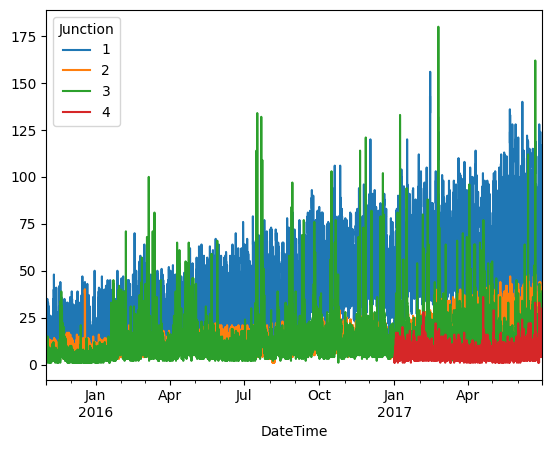

In [14]:
tr.plot()

In [15]:
traffic_df = traffic.resample(rule="D").sum()
traffic_df

,Junction,Vehicles,ID
DateTime,,,
2015-11-01,144,596,1450879280424
2015-11-02,144,909,1450879352424
2015-11-03,144,911,1450879424424
2015-11-04,144,818,1450879496424
2015-11-05,144,770,1450879568424
...,...,...,...
2017-06-26,240,2956,1936380107280
2017-06-27,240,3709,1936380203280
2017-06-28,240,3579,1936380299280


In [18]:
forecaster = Prophet()

In [19]:
horizon = 30

In [45]:
df = traffic_df.columns[0]
forecaster_df = traffic_df[df]

In [46]:
forecaster_df

,Junction
DateTime,
2015-11-01,144
2015-11-02,144
2015-11-03,144
2015-11-04,144
2015-11-05,144
...,...
2017-06-26,240
2017-06-27,240
2017-06-28,240


In [77]:
forecaster_df = forecaster_df.reset_index()           # return the index as a normal column
forecaster_df.columns = ['ds', 'y']
forecaster_df['ds'] = pd.to_datetime(forecaster_df['ds'], errors='coerce')


In [78]:
y_train = forecaster_df[:-horizon]
y_test = forecaster_df.tail(horizon)

In [79]:
y_train

,ds,y
0,2015-11-01,144
1,2015-11-02,144
2,2015-11-03,144
3,2015-11-04,144
4,2015-11-05,144
...,...,...
573,2017-05-27,240
574,2017-05-28,240
575,2017-05-29,240
576,2017-05-30,240


In [25]:
print(y_train.index)


DatetimeIndex(['2015-11-01', '2015-11-02', '2015-11-03', '2015-11-04',
               '2015-11-05', '2015-11-06', '2015-11-07', '2015-11-08',
               '2015-11-09', '2015-11-10',
               ...
               '2017-05-22', '2017-05-23', '2017-05-24', '2017-05-25',
               '2017-05-26', '2017-05-27', '2017-05-28', '2017-05-29',
               '2017-05-30', '2017-05-31'],
              dtype='datetime64[ns]', name='DateTime', length=578, freq='D')


In [81]:
y_train

,index,ds,y
0,0,2015-11-01,144
1,1,2015-11-02,144
2,2,2015-11-03,144
3,3,2015-11-04,144
4,4,2015-11-05,144
...,...,...,...
573,573,2017-05-27,240
574,574,2017-05-28,240
575,575,2017-05-29,240
576,576,2017-05-30,240


In [28]:
forecaster.fit(y_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [30]:
fh

ForecastingHorizon(['2017-06-01', '2017-06-02', '2017-06-03', '2017-06-04',
               '2017-06-05', '2017-06-06', '2017-06-07', '2017-06-08',
               '2017-06-09', '2017-06-10', '2017-06-11', '2017-06-12',
               '2017-06-13', '2017-06-14', '2017-06-15', '2017-06-16',
               '2017-06-17', '2017-06-18', '2017-06-19', '2017-06-20',
               '2017-06-21', '2017-06-22', '2017-06-23', '2017-06-24',
               '2017-06-25', '2017-06-26', '2017-06-27', '2017-06-28',
               '2017-06-29', '2017-06-30'],
              dtype='datetime64[ns]', name='DateTime', freq='D', is_relative=False)

In [53]:
future = forecaster.make_future_dataframe(periods=len(y_test))
forecast = forecaster.predict(future)

In [54]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-11-01,144.080086,134.882812,154.603893,144.080086,144.080086,0.512879,0.512879,0.512879,0.512879,0.512879,0.512879,0.0,0.0,0.0,144.592965
1,2015-11-02,144.079121,135.055552,153.979793,144.079121,144.079121,0.335355,0.335355,0.335355,0.335355,0.335355,0.335355,0.0,0.0,0.0,144.414476
2,2015-11-03,144.078157,134.274585,154.359314,144.078157,144.078157,0.157829,0.157829,0.157829,0.157829,0.157829,0.157829,0.0,0.0,0.0,144.235986
3,2015-11-04,144.077193,134.585997,153.681817,144.077193,144.077193,-0.002706,-0.002706,-0.002706,-0.002706,-0.002706,-0.002706,0.0,0.0,0.0,144.074487
4,2015-11-05,144.076229,133.562160,154.238120,144.076229,144.076229,-0.171729,-0.171729,-0.171729,-0.171729,-0.171729,-0.171729,0.0,0.0,0.0,143.904500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,2017-06-26,238.897458,228.545676,249.132604,235.049012,242.771541,0.335355,0.335355,0.335355,0.335355,0.335355,0.335355,0.0,0.0,0.0,239.232813
604,2017-06-27,238.875188,228.382077,250.506531,234.818544,242.977391,0.157829,0.157829,0.157829,0.157829,0.157829,0.157829,0.0,0.0,0.0,239.033017
605,2017-06-28,238.852918,227.986421,249.227097,234.575713,243.167943,-0.002706,-0.002706,-0.002706,-0.002706,-0.002706,-0.002706,0.0,0.0,0.0,238.850212
606,2017-06-29,238.830648,228.721905,250.342923,234.275889,243.402253,-0.171729,-0.171729,-0.171729,-0.171729,-0.171729,-0.171729,0.0,0.0,0.0,238.658918


In [56]:
y_true = forecaster_df.tail(horizon)
y_true

,Junction
DateTime,
2017-06-01,240
2017-06-02,240
2017-06-03,240
2017-06-04,240
2017-06-05,240
2017-06-06,240
2017-06-07,240
2017-06-08,240
2017-06-09,240


In [58]:
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]


In [59]:
mae = mean_absolute_error(y_true, y_pred)
mae

183.04867879812545

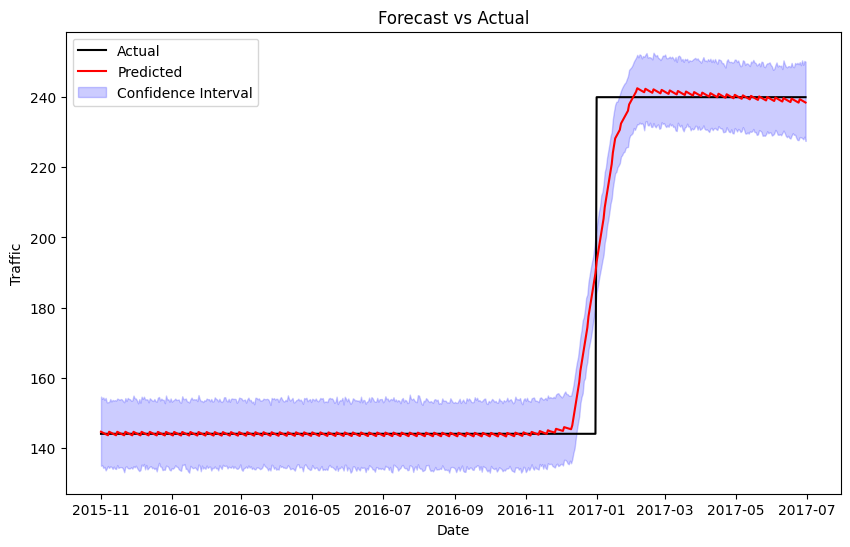

In [83]:
plt.figure(figsize=(10, 6))


plt.plot(forecaster_df['ds'], forecaster_df['y'], label="Actual", color="black")

#(Predicted)
plt.plot(forecast['ds'], forecast['yhat'], label="Predicted", color="red")

# (Confidence Intervals)
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='blue',
    alpha=0.2,
    label='Confidence Interval'
)

plt.title("Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Traffic")
plt.legend()
plt.show()
